In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import PIL
import os
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16, MobileNetV3Small, ConvNeXtTiny
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Flatten, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [2]:
summary_val_acc = {}
summary_train_time = {}

In [3]:
data_dir = 'bigger_ham_sample'
batch_size = 32
seed = 2024
validation_split = 0.15

img_height = 75
img_width = 100


train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1892 files belonging to 7 classes.
Using 1609 files for training.
Found 1892 files belonging to 7 classes.
Using 283 files for validation.


In [4]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Custom CNN

In [29]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [30]:
lr = 0.001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 75, 100, 3)        0         
                                                                 
 conv2d (Conv2D)             (None, 73, 98, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 49, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 47, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 21, 64)        1

In [32]:
epochs = 50

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
51/51 [==============================] - 2s 19ms/step - loss: 1.8269 - accuracy: 0.2306 - val_loss: 1.7157 - val_accuracy: 0.3286
Epoch 2/50
51/51 [==============================] - 1s 13ms/step - loss: 1.6775 - accuracy: 0.3381 - val_loss: 1.6160 - val_accuracy: 0.3569
Epoch 3/50
51/51 [==============================] - 1s 12ms/step - loss: 1.5787 - accuracy: 0.3891 - val_loss: 1.5687 - val_accuracy: 0.3852
Epoch 4/50
51/51 [==============================] - 1s 12ms/step - loss: 1.4575 - accuracy: 0.4357 - val_loss: 1.4355 - val_accuracy: 0.4735
Epoch 5/50
51/51 [==============================] - 1s 12ms/step - loss: 1.3904 - accuracy: 0.4661 - val_loss: 1.3394 - val_accuracy: 0.4700
Epoch 6/50
51/51 [==============================] - 1s 13ms/step - loss: 1.3323 - accuracy: 0.4953 - val_loss: 1.2588 - val_accuracy: 0.5336
Epoch 7/50
51/51 [==============================] - 1s 12ms/step - loss: 1.3055 - accuracy: 0.4997 - val_loss: 1.2827 - val_accuracy: 0.4664
Epoch 8/50
51

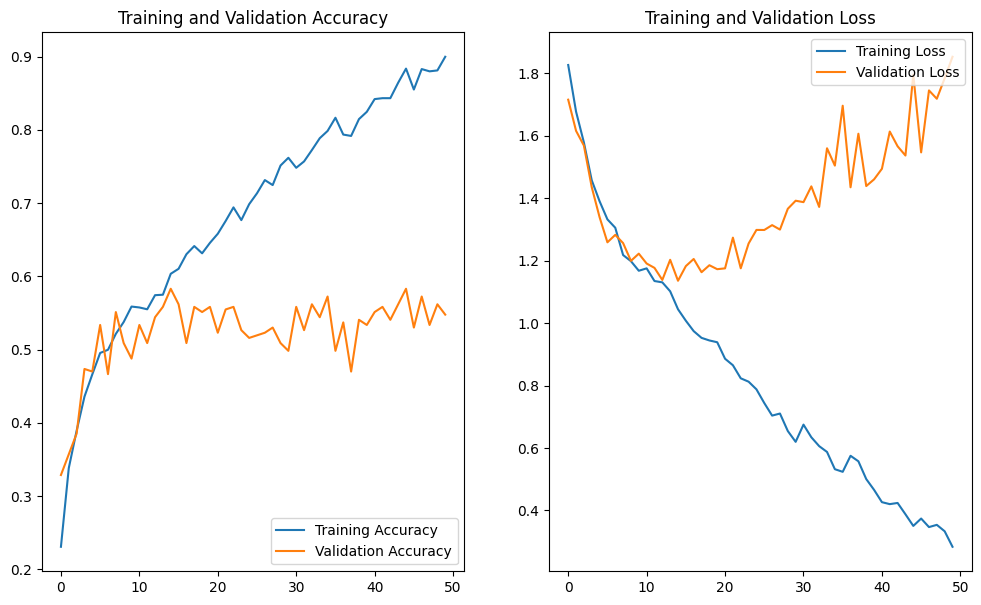

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
summary_val_acc['custom_cnn'] = max(val_acc)
summary_train_time['custom_cnn'] = 12

## VGG16

In [21]:
num_classes = 7

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [22]:
lr = 0.00001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 75, 100, 3)]      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 75, 100, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 75, 100, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 37, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 37, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 37, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 25, 128)       0   

In [24]:
epochs = 30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
51/51 [==============================] - 18s 218ms/step - loss: 3.2910 - accuracy: 0.1678 - val_loss: 1.9631 - val_accuracy: 0.1979
Epoch 2/30
51/51 [==============================] - 7s 141ms/step - loss: 1.9949 - accuracy: 0.2126 - val_loss: 1.8593 - val_accuracy: 0.3145
Epoch 3/30
51/51 [==============================] - 7s 141ms/step - loss: 1.8749 - accuracy: 0.2735 - val_loss: 1.7727 - val_accuracy: 0.4028
Epoch 4/30
51/51 [==============================] - 7s 141ms/step - loss: 1.7979 - accuracy: 0.2996 - val_loss: 1.7211 - val_accuracy: 0.3640
Epoch 5/30
51/51 [==============================] - 7s 142ms/step - loss: 1.7201 - accuracy: 0.3344 - val_loss: 1.6312 - val_accuracy: 0.4028
Epoch 6/30
51/51 [==============================] - 7s 142ms/step - loss: 1.6645 - accuracy: 0.3704 - val_loss: 1.5796 - val_accuracy: 0.4064
Epoch 7/30
51/51 [==============================] - 7s 141ms/step - loss: 1.5944 - accuracy: 0.4052 - val_loss: 1.5391 - val_accuracy: 0.4558
Epoch

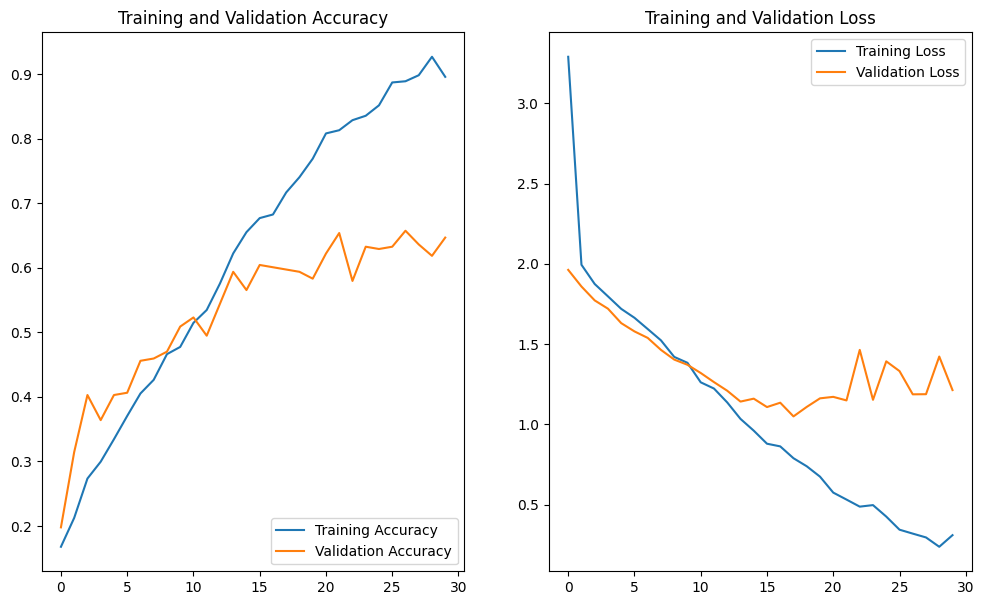

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
summary_val_acc['vgg16'] = max(val_acc)
summary_train_time['vgg16'] = 145

## MobileNET

In [12]:
num_classes = 7

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 75, 100, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 rescaling (Rescaling)          (None, 75, 100, 3)   0           ['input_2[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 38, 50, 16)   432         ['rescaling[0][0]']              
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 38, 50, 16)  64          ['Conv[0][0]']             

 re_lu_4 (ReLU)                 (None, 10, 13, 72)   0           ['expanded_conv_1/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_1/project (Conv2  (None, 10, 13, 24)  1728        ['re_lu_4[0][0]']                
 D)                                                                                               
                                                                                                  
 expanded_conv_1/project/BatchN  (None, 10, 13, 24)  96          ['expanded_conv_1/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_2/expand (Conv2D  (None, 10, 13, 88)  2112        ['expanded_conv_1/project/BatchNo
 )        

                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 24)    0           ['expanded_conv_3/squeeze_excite/
 /Relu (ReLU)                                                    Conv[0][0]']                     
                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 96)    2400        ['expanded_conv_3/squeeze_excite/
 /Conv_1 (Conv2D)                                                Relu[0][0]']                     
                                                                                                  
 tf.__operators__.add_22 (TFOpL  (None, 1, 1, 96)    0           ['expanded_conv_3/squeeze_excite/
 ambda)                                                          Conv_1[0][0]']                   
                                                                                                  
 re_lu_9 (

                                                                                                  
 expanded_conv_4/project (Conv2  (None, 5, 7, 40)    9600        ['expanded_conv_4/squeeze_excite/
 D)                                                              Mul[0][0]']                      
                                                                                                  
 expanded_conv_4/project/BatchN  (None, 5, 7, 40)    160         ['expanded_conv_4/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_4/Add (Add)      (None, 5, 7, 40)     0           ['expanded_conv_3/project/BatchNo
                                                                 rm[0][0]',                       
                                                                  'expanded_conv_4/project/BatchNo
          

 )                                                                                                
                                                                                                  
 expanded_conv_6/expand/BatchNo  (None, 5, 7, 120)   480         ['expanded_conv_6/expand[0][0]'] 
 rm (BatchNormalization)                                                                          
                                                                                                  
 tf.__operators__.add_29 (TFOpL  (None, 5, 7, 120)   0           ['expanded_conv_6/expand/BatchNor
 ambda)                                                          m[0][0]']                        
                                                                                                  
 re_lu_16 (ReLU)                (None, 5, 7, 120)    0           ['tf.__operators__.add_29[0][0]']
                                                                                                  
 tf.math.m

 expanded_conv_7/depthwise (Dep  (None, 5, 7, 144)   3600        ['multiply_9[0][0]']             
 thwiseConv2D)                                                                                    
                                                                                                  
 expanded_conv_7/depthwise/Batc  (None, 5, 7, 144)   576         ['expanded_conv_7/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 tf.__operators__.add_33 (TFOpL  (None, 5, 7, 144)   0           ['expanded_conv_7/depthwise/Batch
 ambda)                                                          Norm[0][0]']                     
                                                                                                  
 re_lu_20 (ReLU)                (None, 5, 7, 144)    0           ['tf.__operators__.add_33[0][0]']
          

 re_lu_23 (ReLU)                (None, 3, 4, 288)    0           ['tf.__operators__.add_36[0][0]']
                                                                                                  
 tf.math.multiply_18 (TFOpLambd  (None, 3, 4, 288)   0           ['re_lu_23[0][0]']               
 a)                                                                                               
                                                                                                  
 multiply_12 (Multiply)         (None, 3, 4, 288)    0           ['expanded_conv_8/depthwise/Batch
                                                                 Norm[0][0]',                     
                                                                  'tf.math.multiply_18[0][0]']    
                                                                                                  
 expanded_conv_8/squeeze_excite  (None, 1, 1, 288)   0           ['multiply_12[0][0]']            
 /AvgPool 

 /Relu (ReLU)                                                    Conv[0][0]']                     
                                                                                                  
 expanded_conv_9/squeeze_excite  (None, 1, 1, 576)   83520       ['expanded_conv_9/squeeze_excite/
 /Conv_1 (Conv2D)                                                Relu[0][0]']                     
                                                                                                  
 tf.__operators__.add_40 (TFOpL  (None, 1, 1, 576)   0           ['expanded_conv_9/squeeze_excite/
 ambda)                                                          Conv_1[0][0]']                   
                                                                                                  
 re_lu_27 (ReLU)                (None, 1, 1, 576)    0           ['tf.__operators__.add_40[0][0]']
                                                                                                  
 tf.math.m

                                                                                                  
 expanded_conv_10/squeeze_excit  (None, 3, 4, 576)   0           ['multiply_16[0][0]',            
 e/Mul (Multiply)                                                 'tf.math.multiply_25[0][0]']    
                                                                                                  
 expanded_conv_10/project (Conv  (None, 3, 4, 96)    55296       ['expanded_conv_10/squeeze_excite
 2D)                                                             /Mul[0][0]']                     
                                                                                                  
 expanded_conv_10/project/Batch  (None, 3, 4, 96)    384         ['expanded_conv_10/project[0][0]'
 Norm (BatchNormalization)                                       ]                                
                                                                                                  
 expanded_

In [15]:
lr = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
epochs = 70

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/70
51/51 [==============================] - 7s 58ms/step - loss: 2.0820 - accuracy: 0.1616 - val_loss: 1.9665 - val_accuracy: 0.1519
Epoch 2/70
51/51 [==============================] - 2s 45ms/step - loss: 1.8500 - accuracy: 0.2206 - val_loss: 1.9379 - val_accuracy: 0.1802
Epoch 3/70
51/51 [==============================] - 2s 46ms/step - loss: 1.7207 - accuracy: 0.3052 - val_loss: 1.9150 - val_accuracy: 0.1943
Epoch 4/70
51/51 [==============================] - 2s 45ms/step - loss: 1.6098 - accuracy: 0.3717 - val_loss: 1.8805 - val_accuracy: 0.2155
Epoch 5/70
51/51 [==============================] - 2s 46ms/step - loss: 1.4801 - accuracy: 0.4394 - val_loss: 1.8372 - val_accuracy: 0.2085
Epoch 6/70
51/51 [==============================] - 2s 45ms/step - loss: 1.3325 - accuracy: 0.5016 - val_loss: 1.7911 - val_accuracy: 0.2544
Epoch 7/70
51/51 [==============================] - 2s 45ms/step - loss: 1.1997 - accuracy: 0.5612 - val_loss: 1.7788 - val_accuracy: 0.2544
Epoch 8/70
51

Epoch 59/70
51/51 [==============================] - 2s 46ms/step - loss: 0.0117 - accuracy: 0.9969 - val_loss: 3.1126 - val_accuracy: 0.5654
Epoch 60/70
51/51 [==============================] - 2s 46ms/step - loss: 0.0092 - accuracy: 0.9981 - val_loss: 3.1077 - val_accuracy: 0.5618
Epoch 61/70
51/51 [==============================] - 2s 46ms/step - loss: 0.0086 - accuracy: 0.9981 - val_loss: 3.2194 - val_accuracy: 0.5477
Epoch 62/70
51/51 [==============================] - 2s 46ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 3.2330 - val_accuracy: 0.5548
Epoch 63/70
51/51 [==============================] - 2s 46ms/step - loss: 0.0077 - accuracy: 0.9988 - val_loss: 3.3474 - val_accuracy: 0.5477
Epoch 64/70
51/51 [==============================] - 2s 46ms/step - loss: 0.0046 - accuracy: 0.9994 - val_loss: 3.3462 - val_accuracy: 0.5548
Epoch 65/70
51/51 [==============================] - 2s 46ms/step - loss: 0.0037 - accuracy: 0.9994 - val_loss: 3.3135 - val_accuracy: 0.5548
Epoch 

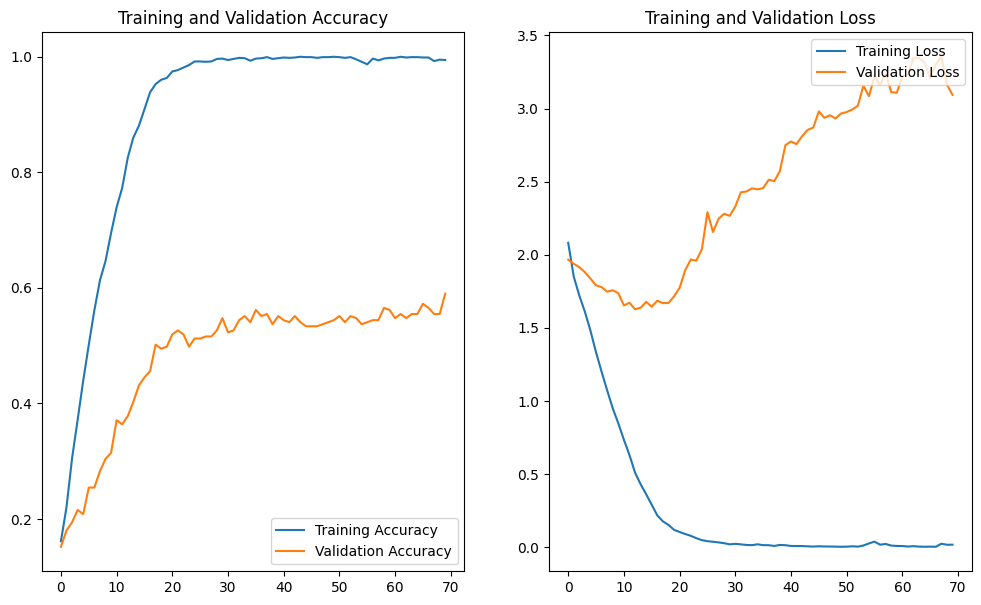

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
summary_val_acc['mobilenet_small'] = max(val_acc)
summary_train_time['mobilenet_small'] = 44
summary_val_acc

{'convnext_tiny': 0.703180193901062, 'mobilenet_small': 0.5901060104370117}

## ConvNeXt

In [6]:
num_classes = 7

base_model = ConvNeXtTiny(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

111650432/111650432 [==============================] - 4s 0us/step


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 100, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 convnext_tiny_prestem_normaliz  (None, 75, 100, 3)  0           ['input_1[0][0]']                
 ation (Normalization)                                                                            
                                                                                                  
 convnext_tiny_stem (Sequential  (None, 18, 25, 96)  4896        ['convnext_tiny_prestem_normaliza
 )                                                               tion[0][0]']                 

 tf.__operators__.add_2 (TFOpLa  (None, 18, 25, 96)  0           ['tf.__operators__.add_1[0][0]', 
 mbda)                                                            'convnext_tiny_stage_0_block_2_i
                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_tiny_downsampling_blo  (None, 9, 12, 192)  74112       ['tf.__operators__.add_2[0][0]'] 
 ck_0 (Sequential)                                                                                
                                                                                                  
 convnext_tiny_stage_1_block_0_  (None, 9, 12, 192)  9600        ['convnext_tiny_downsampling_bloc
 depthwise_conv (Conv2D)                                         k_0[0][0]']                      
                                                                                                  
 convnext_

 convnext_tiny_downsampling_blo  (None, 4, 6, 384)   295680      ['tf.__operators__.add_5[0][0]'] 
 ck_1 (Sequential)                                                                                
                                                                                                  
 convnext_tiny_stage_2_block_0_  (None, 4, 6, 384)   19200       ['convnext_tiny_downsampling_bloc
 depthwise_conv (Conv2D)                                         k_1[0][0]']                      
                                                                                                  
 convnext_tiny_stage_2_block_0_  (None, 4, 6, 384)   768         ['convnext_tiny_stage_2_block_0_d
 layernorm (LayerNormalization)                                  epthwise_conv[0][0]']            
                                                                                                  
 convnext_tiny_stage_2_block_0_  (None, 4, 6, 1536)  591360      ['convnext_tiny_stage_2_block_0_l
 pointwise

 layernorm (LayerNormalization)                                  epthwise_conv[0][0]']            
                                                                                                  
 convnext_tiny_stage_2_block_3_  (None, 4, 6, 1536)  591360      ['convnext_tiny_stage_2_block_3_l
 pointwise_conv_1 (Dense)                                        ayernorm[0][0]']                 
                                                                                                  
 convnext_tiny_stage_2_block_3_  (None, 4, 6, 1536)  0           ['convnext_tiny_stage_2_block_3_p
 gelu (Activation)                                               ointwise_conv_1[0][0]']          
                                                                                                  
 convnext_tiny_stage_2_block_3_  (None, 4, 6, 384)   590208      ['convnext_tiny_stage_2_block_3_g
 pointwise_conv_2 (Dense)                                        elu[0][0]']                      
          

 convnext_tiny_stage_2_block_6_  (None, 4, 6, 384)   590208      ['convnext_tiny_stage_2_block_6_g
 pointwise_conv_2 (Dense)                                        elu[0][0]']                      
                                                                                                  
 convnext_tiny_stage_2_block_6_  (None, 4, 6, 384)   384         ['convnext_tiny_stage_2_block_6_p
 layer_scale (LayerScale)                                        ointwise_conv_2[0][0]']          
                                                                                                  
 convnext_tiny_stage_2_block_6_  (None, 4, 6, 384)   0           ['convnext_tiny_stage_2_block_6_l
 identity (Activation)                                           ayer_scale[0][0]']               
                                                                                                  
 tf.__operators__.add_12 (TFOpL  (None, 4, 6, 384)   0           ['tf.__operators__.add_11[0][0]',
 ambda)   

                                                                                                  
 convnext_tiny_stage_3_block_0_  (None, 2, 3, 768)   0           ['convnext_tiny_stage_3_block_0_l
 identity (Activation)                                           ayer_scale[0][0]']               
                                                                                                  
 tf.__operators__.add_15 (TFOpL  (None, 2, 3, 768)   0           ['convnext_tiny_downsampling_bloc
 ambda)                                                          k_2[0][0]',                      
                                                                  'convnext_tiny_stage_3_block_0_i
                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_tiny_stage_3_block_1_  (None, 2, 3, 768)   38400       ['tf.__operators__.add_15[0][0]']
 depthwise

In [8]:
lr = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


C:\Users\Miko7\miniconda3\envs\tf\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


51/51 [==============================] - 32s 333ms/step - loss: 2.0101 - accuracy: 0.1995 - val_loss: 1.6825 - val_accuracy: 0.3675
Epoch 2/20
51/51 [==============================] - 13s 263ms/step - loss: 1.6520 - accuracy: 0.3406 - val_loss: 1.4364 - val_accuracy: 0.4523
Epoch 3/20
51/51 [==============================] - 13s 264ms/step - loss: 1.3701 - accuracy: 0.4612 - val_loss: 1.2269 - val_accuracy: 0.5548
Epoch 4/20
51/51 [==============================] - 13s 264ms/step - loss: 1.1198 - accuracy: 0.5637 - val_loss: 1.0508 - val_accuracy: 0.6184
Epoch 5/20
51/51 [==============================] - 14s 265ms/step - loss: 0.8886 - accuracy: 0.6663 - val_loss: 0.9821 - val_accuracy: 0.6714
Epoch 6/20
51/51 [==============================] - 13s 265ms/step - loss: 0.6712 - accuracy: 0.7669 - val_loss: 1.0752 - val_accuracy: 0.6254
Epoch 7/20
51/51 [==============================] - 14s 266ms/step - loss: 0.4841 - accuracy: 0.8446 - val_loss: 1.0575 - val_accuracy: 0.6784
Epoch 8/20

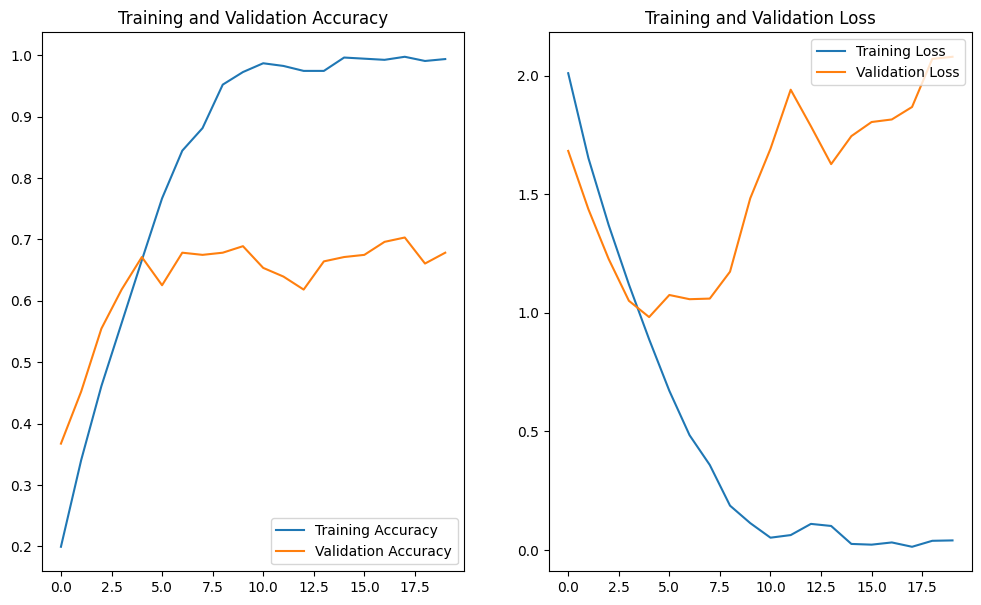

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
summary_val_acc['convnext_tiny'] = max(val_acc)
summary_train_time['convnext_tiny'] = 265
summary_val_acc

{'convnext_tiny': 0.703180193901062}

In [37]:
summary_val_acc

{'convnext_tiny': 0.703180193901062,
 'mobilenet_small': 0.5901060104370117,
 'vgg16': 0.6572437882423401,
 'custom_cnn': 0.583038866519928}

In [38]:
summary_train_time

{'convnext_tiny': 265, 'mobilenet_small': 44, 'vgg16': 145, 'custom_cnn': 12}

In [55]:
parameters_num = {'convnext_tiny': 28283879,
 'mobilenet_small': 1124087,
 'vgg16': 15538631,
 'custom_cnn': 605863}

## ConvNeXtTiny on bigger images

In [3]:
data_dir = 'bigger_ham_sample'
batch_size = 32
seed = 2024
img_height = 75
img_width = 100

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1892 files belonging to 7 classes.


In [14]:
test_data_dir = 'test_ham_sample'

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  image_size=(img_height, img_width),
  shuffle=False,)

Found 350 files belonging to 7 classes.


In [7]:
num_classes = 7

base_model = ConvNeXtTiny(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [8]:
lr = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 100, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 convnext_tiny_prestem_normaliz  (None, 75, 100, 3)  0           ['input_1[0][0]']                
 ation (Normalization)                                                                            
                                                                                                  
 convnext_tiny_stem (Sequential  (None, 18, 25, 96)  4896        ['convnext_tiny_prestem_normaliza
 )                                                               tion[0][0]']                 

 tf.__operators__.add_2 (TFOpLa  (None, 18, 25, 96)  0           ['tf.__operators__.add_1[0][0]', 
 mbda)                                                            'convnext_tiny_stage_0_block_2_i
                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_tiny_downsampling_blo  (None, 9, 12, 192)  74112       ['tf.__operators__.add_2[0][0]'] 
 ck_0 (Sequential)                                                                                
                                                                                                  
 convnext_tiny_stage_1_block_0_  (None, 9, 12, 192)  9600        ['convnext_tiny_downsampling_bloc
 depthwise_conv (Conv2D)                                         k_0[0][0]']                      
                                                                                                  
 convnext_

 convnext_tiny_downsampling_blo  (None, 4, 6, 384)   295680      ['tf.__operators__.add_5[0][0]'] 
 ck_1 (Sequential)                                                                                
                                                                                                  
 convnext_tiny_stage_2_block_0_  (None, 4, 6, 384)   19200       ['convnext_tiny_downsampling_bloc
 depthwise_conv (Conv2D)                                         k_1[0][0]']                      
                                                                                                  
 convnext_tiny_stage_2_block_0_  (None, 4, 6, 384)   768         ['convnext_tiny_stage_2_block_0_d
 layernorm (LayerNormalization)                                  epthwise_conv[0][0]']            
                                                                                                  
 convnext_tiny_stage_2_block_0_  (None, 4, 6, 1536)  591360      ['convnext_tiny_stage_2_block_0_l
 pointwise

 layernorm (LayerNormalization)                                  epthwise_conv[0][0]']            
                                                                                                  
 convnext_tiny_stage_2_block_3_  (None, 4, 6, 1536)  591360      ['convnext_tiny_stage_2_block_3_l
 pointwise_conv_1 (Dense)                                        ayernorm[0][0]']                 
                                                                                                  
 convnext_tiny_stage_2_block_3_  (None, 4, 6, 1536)  0           ['convnext_tiny_stage_2_block_3_p
 gelu (Activation)                                               ointwise_conv_1[0][0]']          
                                                                                                  
 convnext_tiny_stage_2_block_3_  (None, 4, 6, 384)   590208      ['convnext_tiny_stage_2_block_3_g
 pointwise_conv_2 (Dense)                                        elu[0][0]']                      
          

 convnext_tiny_stage_2_block_6_  (None, 4, 6, 384)   590208      ['convnext_tiny_stage_2_block_6_g
 pointwise_conv_2 (Dense)                                        elu[0][0]']                      
                                                                                                  
 convnext_tiny_stage_2_block_6_  (None, 4, 6, 384)   384         ['convnext_tiny_stage_2_block_6_p
 layer_scale (LayerScale)                                        ointwise_conv_2[0][0]']          
                                                                                                  
 convnext_tiny_stage_2_block_6_  (None, 4, 6, 384)   0           ['convnext_tiny_stage_2_block_6_l
 identity (Activation)                                           ayer_scale[0][0]']               
                                                                                                  
 tf.__operators__.add_12 (TFOpL  (None, 4, 6, 384)   0           ['tf.__operators__.add_11[0][0]',
 ambda)   

                                                                                                  
 convnext_tiny_stage_3_block_0_  (None, 2, 3, 768)   0           ['convnext_tiny_stage_3_block_0_l
 identity (Activation)                                           ayer_scale[0][0]']               
                                                                                                  
 tf.__operators__.add_15 (TFOpL  (None, 2, 3, 768)   0           ['convnext_tiny_downsampling_bloc
 ambda)                                                          k_2[0][0]',                      
                                                                  'convnext_tiny_stage_3_block_0_i
                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_tiny_stage_3_block_1_  (None, 2, 3, 768)   38400       ['tf.__operators__.add_15[0][0]']
 depthwise

In [10]:
epochs = 20

history = model.fit(
  train_ds,
  epochs=epochs
)

Epoch 1/20


C:\Users\Miko7\miniconda3\envs\tf\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


60/60 [==============================] - 30s 266ms/step - loss: 1.9518 - accuracy: 0.2225
Epoch 2/20
60/60 [==============================] - 15s 246ms/step - loss: 1.5912 - accuracy: 0.3626
Epoch 3/20
60/60 [==============================] - 15s 249ms/step - loss: 1.2757 - accuracy: 0.5206
Epoch 4/20
60/60 [==============================] - 15s 248ms/step - loss: 1.0899 - accuracy: 0.5925
Epoch 5/20
60/60 [==============================] - 14s 239ms/step - loss: 0.8219 - accuracy: 0.6961
Epoch 6/20
60/60 [==============================] - 15s 244ms/step - loss: 0.5873 - accuracy: 0.8044
Epoch 7/20
60/60 [==============================] - 15s 244ms/step - loss: 0.3896 - accuracy: 0.8779
Epoch 8/20
60/60 [==============================] - 15s 245ms/step - loss: 0.3031 - accuracy: 0.9107
Epoch 9/20
60/60 [==============================] - 15s 246ms/step - loss: 0.1647 - accuracy: 0.9498
Epoch 10/20
60/60 [==============================] - 15s 244ms/step - loss: 0.1164 - accuracy: 0.9635


In [15]:
predictions = model.predict(test_ds)

y_pred = np.argmax(predictions, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)  # Concatenate true labels from the dataset

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

11/11 [==============================] - 1s 79ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        50
           1       0.84      0.74      0.79        50
           2       0.91      0.40      0.56        50
           3       0.96      1.00      0.98        50
           4       0.59      0.84      0.69        50
           5       0.91      0.78      0.84        50
           6       0.91      1.00      0.95        50

    accuracy                           0.82       350
   macro avg       0.84      0.82      0.81       350
weighted avg       0.84      0.82      0.81       350

Confusion Matrix:
[[50  0  0  0  0  0  0]
 [ 5 37  0  0  4  0  4]
 [ 5  6 20  0 17  2  0]
 [ 0  0  0 50  0  0  0]
 [ 2  1  2  1 42  2  0]
 [ 1  0  0  1  8 39  1]
 [ 0  0  0  0  0  0 50]]


In [16]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 4, 1, 0, 1, 1, 6, 1, 4, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       4, 1, 6, 6, 1, 1, 1, 0, 1, 1, 6, 1, 2, 4, 1, 4, 2, 4, 0, 4, 4, 2,
       4, 2, 4, 1, 5, 2, 0, 2, 4, 4, 1, 2, 2, 1, 4, 2, 2, 1, 4, 4, 4, 2,
       0, 0, 2, 2, 4, 2, 2, 0, 5, 2, 2, 2, 2, 1, 4, 4, 2, 4, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 2, 4, 4, 4, 0, 2, 4, 4, 4, 5, 4, 4, 4, 1, 4, 4, 0, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       4, 5, 5, 5, 0, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 4,
       5, 5, 5, 4, 5, 5, 3, 5, 5, 5, 4, 4, 5, 5, 6,

In [17]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6,

In [19]:
model.save("saved_conv_next")

INFO:tensorflow:Assets written to: saved_conv_next\assets


INFO:tensorflow:Assets written to: saved_conv_next\assets


In [20]:
labels = test_ds.class_names
labels

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

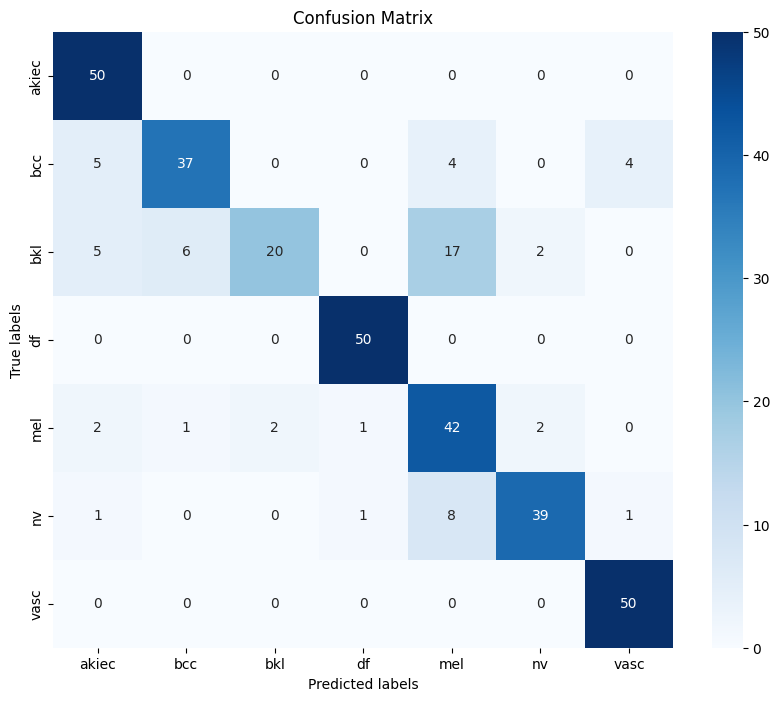

In [26]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d",
            xticklabels=labels,
            yticklabels=labels)

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [35]:
summary_val_acc = {'convnext_tiny': 0.703180193901062,
 'mobilenet_small': 0.5901060104370117,
 'vgg16': 0.6572437882423401,
 'custom_cnn': 0.583038866519928}

In [33]:
combined_model_codes = ['custom_cnn', 'vgg16', 'mobilenet_small', 'convnext_tiny', ]

combined_labels = {'convnext_tiny': "ConvNeXt Tiny",
 'mobilenet_small': "MobileNetV3 Small",
 'vgg16': "VGG16",
 'custom_cnn': "Custom CNN"}

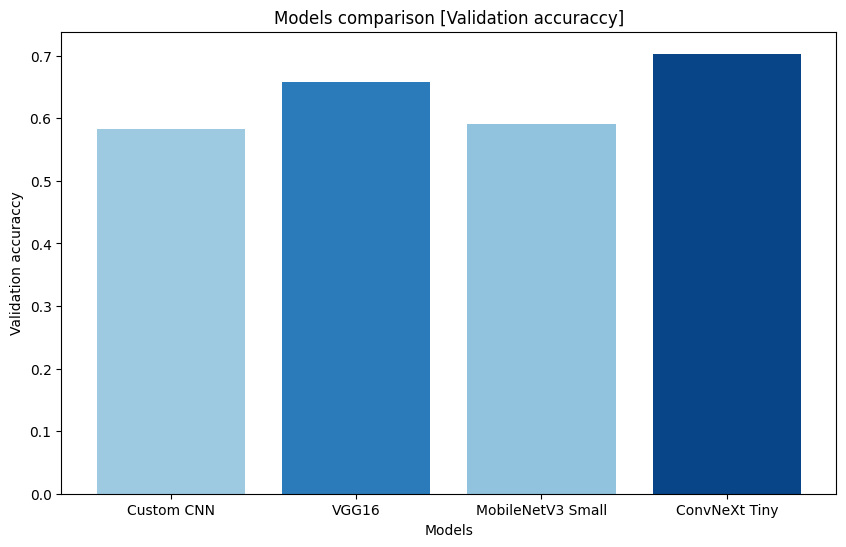

In [50]:
plt.figure(figsize=(10, 6))
categories = [combined_labels[code] for code in combined_model_codes]
values = [summary_val_acc[code] for code in combined_model_codes]

cmap = plt.cm.Blues

norm = plt.Normalize(0.5, 0.72)
plt.bar(categories, values, color=cmap(norm(values)))


plt.xlabel('Models')
plt.ylabel('Validation accuraccy')
plt.title('Models comparison [Validation accuraccy]')
plt.show()

In [51]:
summary_train_time = {'convnext_tiny': 265, 'mobilenet_small': 44, 'vgg16': 145, 'custom_cnn': 12}

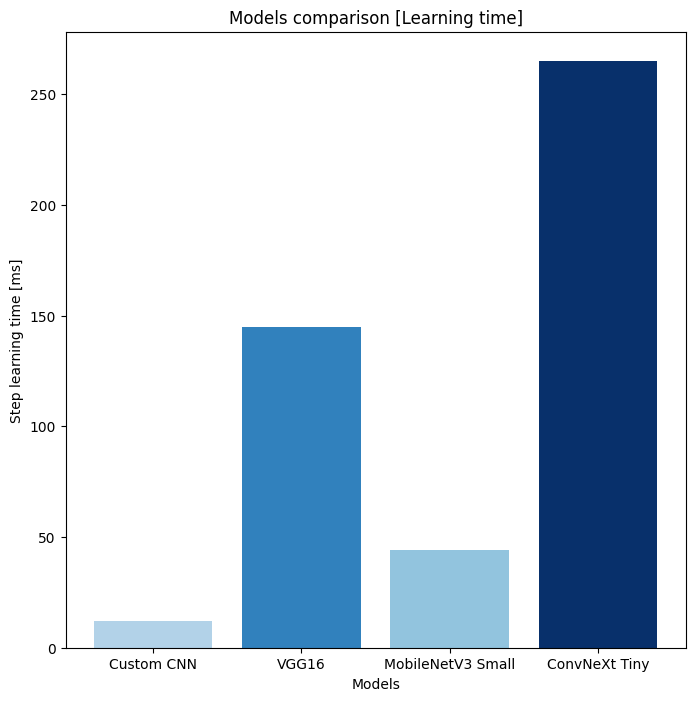

In [61]:
plt.figure(figsize=(8, 8))
categories = [combined_labels[code] for code in combined_model_codes]
values = [summary_train_time[code] for code in combined_model_codes]

cmap = plt.cm.Blues

norm = plt.Normalize(-100, 256)
plt.bar(categories, values, color=cmap(norm(values)))


plt.xlabel('Models')
plt.ylabel('Step learning time [ms]')
plt.title('Models comparison [Learning time]')
plt.show()

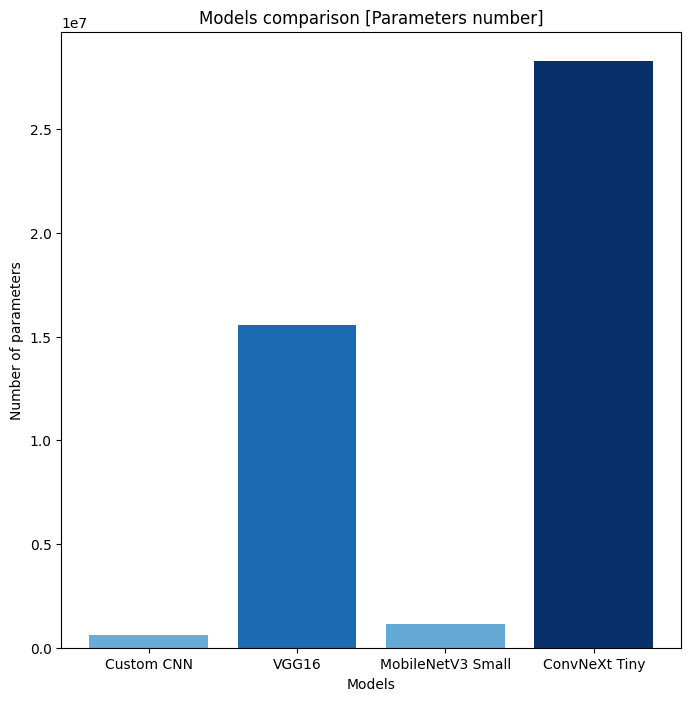

In [62]:
plt.figure(figsize=(8, 8))
categories = [combined_labels[code] for code in combined_model_codes]
values = [parameters_num[code] for code in combined_model_codes]

cmap = plt.cm.Blues

norm = plt.Normalize(-max(values), max(values))
plt.bar(categories, values, color=cmap(norm(values)))


plt.xlabel('Models')
plt.ylabel('Number of parameters')
plt.title('Models comparison [Parameters number]')
plt.show()